<a href="https://colab.research.google.com/github/harshbisla/Gold-price-prediction-using-time-series/blob/main/Gold_Price_Prediction_(time_Series).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing , SimpleExpSmoothing , Holt
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [10]:
df = pd.read_csv('/content/gold_monthly_csv.csv')
df.head()

,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


In [11]:
df.shape

(847, 2)

Exploratory data analysis (EDA)

In [12]:
print(f"Date range of gold prices available from  - {df.loc[:,'Date'][0]} to {df.loc[:,'Date'][len(df)-1]}")


Date range of gold prices available from  - 1950-01 to 2020-07


In [17]:
date = pd.date_range(start = '1/1/1950' , end = '8/1/2020' , freq = 'M')

In [14]:
df['month'] = date
df.drop('Date' , axis =1,inplace = True)
df = df.set_index('month')

In [18]:
df.head()


,Price
month,
1950-01-31,34.73
1950-02-28,34.73
1950-03-31,34.73
1950-04-30,34.73
1950-05-31,34.73


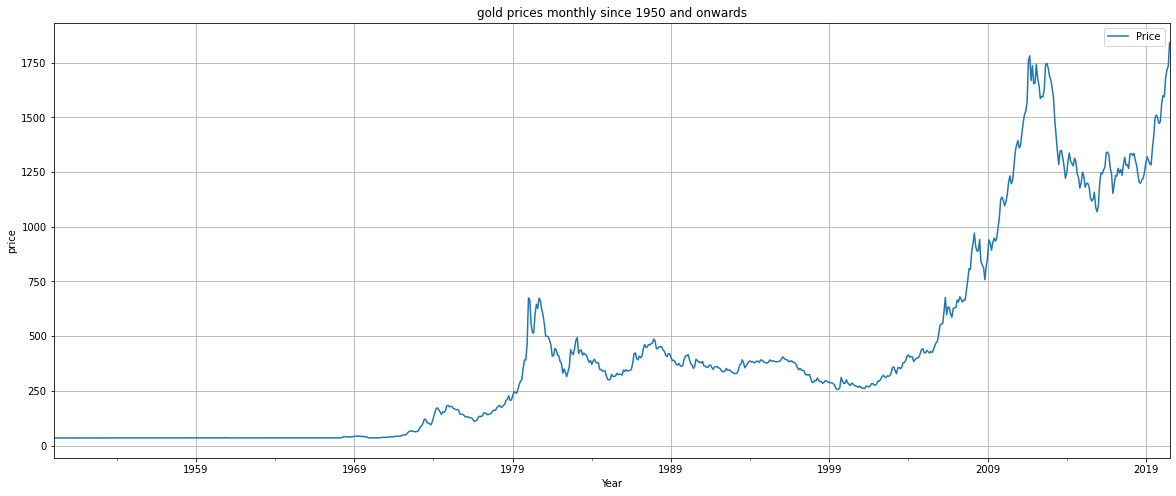

In [23]:
df.plot(figsize = (20,8))
plt.title("gold prices monthly since 1950 and onwards")
plt.xlabel("Year")
plt.ylabel('price')
plt.grid()

In [21]:
round(df.describe(),3)

,Price
count,847.000
mean,416.557
std,453.665
min,34.490
25%,35.190
50%,319.622
75%,447.029
max,1840.807


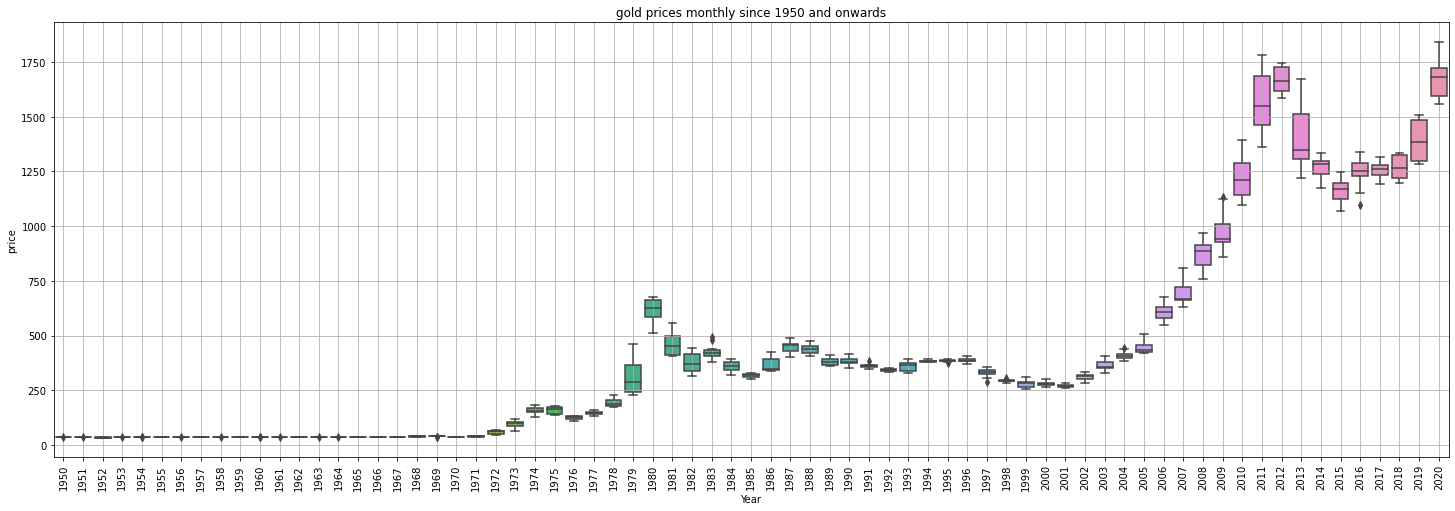

In [24]:
_, ax= plt.subplots(figsize = (25,8))
sns.boxplot(x = df.index.year , y = df.values[: , 0],ax=ax)
plt.title("gold prices monthly since 1950 and onwards")
plt.xlabel("Year")
plt.ylabel('price')
plt.xticks(rotation = 90)
plt.grid()

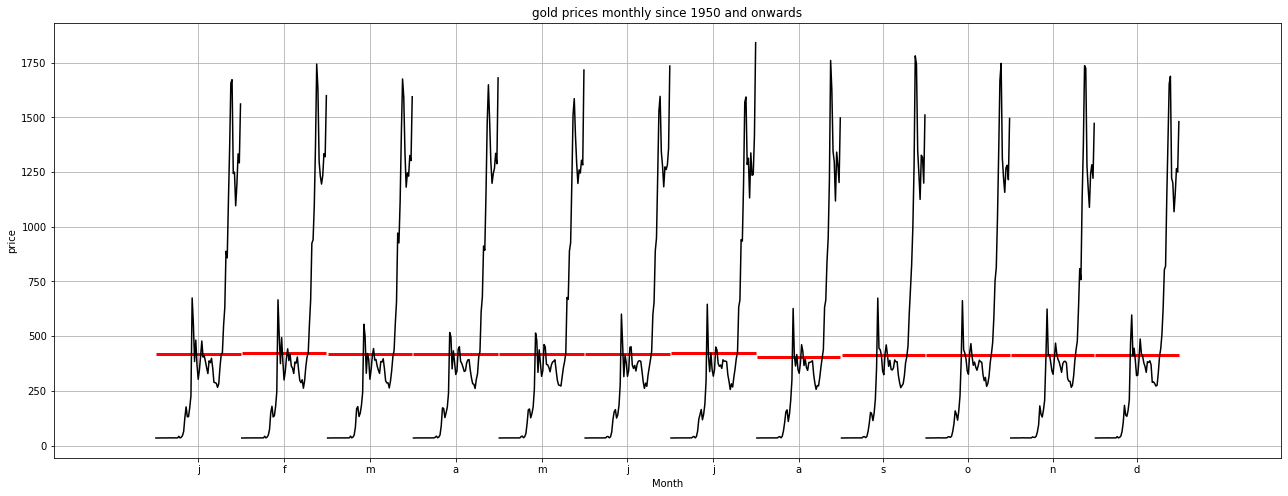

In [26]:
from statsmodels.graphics.tsaplots import month_plot

fig,ax = plt.subplots(figsize = (22,8))
month_plot(df,ylabel = 'Gold Price',ax =ax)
plt.title("gold prices monthly since 1950 and onwards")
plt.xlabel("Month")
plt.ylabel('price')
plt.grid()

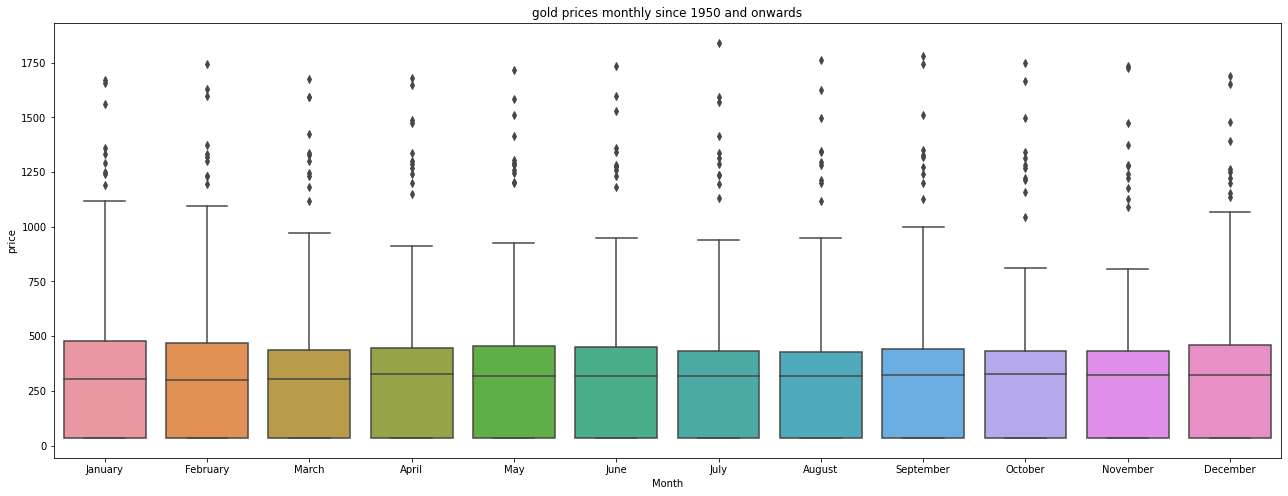

In [28]:
_ , ax = plt.subplots(figsize = (22,8))
sns.boxplot(x= df.index.month_name() , y = df.values[:,0],ax=ax)
plt.title("gold prices monthly since 1950 and onwards")
plt.xlabel("Month")
plt.ylabel('price')
plt.show()

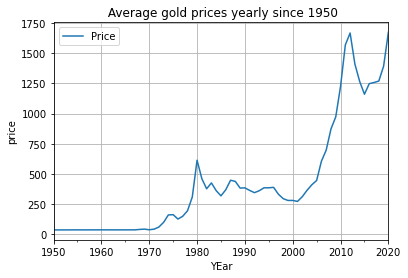

In [30]:
df_yearly_sum = df.resample('A').mean()
df_yearly_sum.plot()
plt.title(" Average gold prices yearly since 1950")
plt.xlabel("Year")
plt.ylabel('price')

plt.grid()


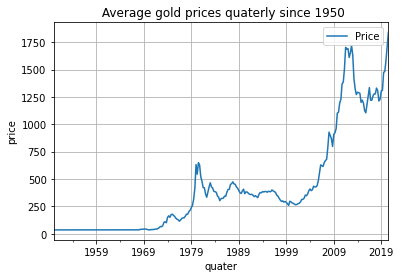

In [34]:
df_quaterly_sum = df.resample('Q').mean()
df_quaterly_sum.plot()
plt.title(" Average gold prices quaterly since 1950")
plt.xlabel("quater")
plt.ylabel('price')

plt.grid()

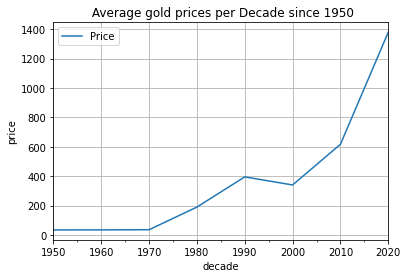

In [35]:
df_decade_sum = df.resample('10Y').mean()
df_decade_sum.plot()
plt.title(" Average gold prices per Decade since 1950")
plt.xlabel("decade")
plt.ylabel('price')

plt.grid()

In [40]:
df_1 = df.groupby(df.index.year).mean().rename(columns= {'Price':'Mean'})
df_1 = df_1.merge(df.groupby(df.index.year).std().rename(columns = {'Price':'Std'}),left_index = True , right_index = True)

In [41]:
df_1['Cov_pct'] = ((df_1['Std']/df_1["Mean"])*100).round(2)
df_1.head()

,Mean,Std,Cov_pct
month,,,
1950,34.729167,0.002887,0.01
1951,34.717500,0.020057,0.06
1952,34.628333,0.117538,0.34
1953,34.879167,0.056481,0.16
1954,35.020000,0.082792,0.24


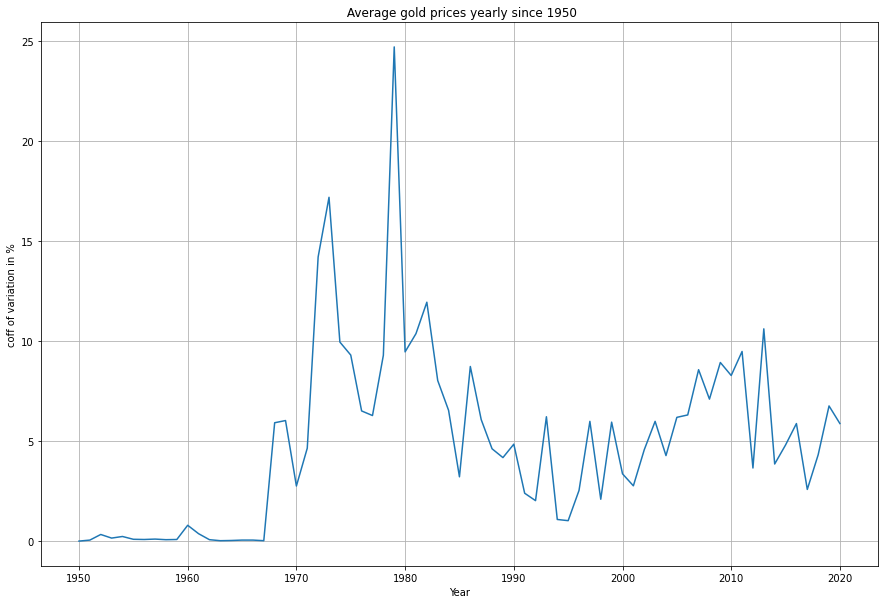

In [43]:
fig, ax = plt.subplots(figsize =(15,10))
df_1['Cov_pct'].plot()
plt.title(" Average gold prices yearly since 1950")
plt.xlabel("Year")
plt.ylabel('coff of variation in %')

plt.grid()

In [44]:
train = df[df.index.year<= 2015]
test = df[df.index.year>2015]

In [45]:
print(train.shape)
print(test.shape)

(792, 1)
(55, 1)


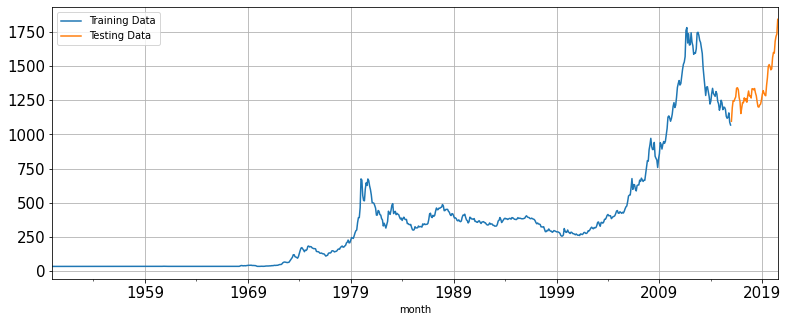

In [47]:
train["Price"].plot(figsize = (13,5),fontsize =15)
test["Price"].plot(figsize = (13,5),fontsize =15)
plt.grid()
plt.legend(['Training Data','Testing Data'])

Model Formation

Linear Regression

In [48]:
train_time = [i+1 for i in range (len(train))]
test_time = [i+len(train)+1 for i in range(len(test))]
len(train_time),len(test_time)

(792, 55)

In [49]:
 LR_train = train.copy()
 LR_test = test.copy()

In [50]:
LR_train['time'] = train_time
LR_test['time'] = test_time

In [53]:
lr = LinearRegression()
lr.fit(LR_train[['time']],LR_train["Price"].values)

LinearRegression()

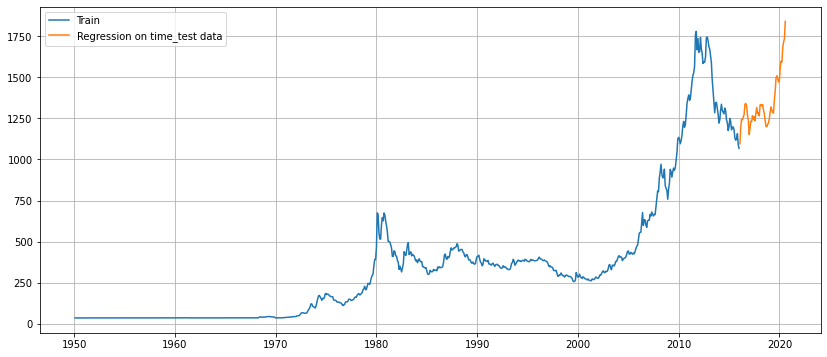

In [54]:
test_pred_model_1 = lr.predict(LR_test[["time"]])
LR_test['forecast'] = test_pred_model_1

plt.figure(figsize = (14,6))
plt.plot(train['Price'],label = 'Train')
plt.plot(LR_test['Price'],label = 'Regression on time_test data')
plt.legend(loc = 'best')
plt.grid()

In [56]:
def mape(actual,pred):
  return round((np.mean(abs(actual-pred)/actual))*100,2)

In [59]:
mape_model_1_test = mape(test['Price'].values,test_pred_model_1)
print("Mape is %3.3f"%(mape_model_1_test),"%")

Mape is 29.760 %


In [63]:
results = pd.DataFrame({'Test Mape (%)' :[mape_model_1_test]},index=["RegressionOnTime"])
results

,Test Mape (%)
RegressionOnTime,29.76


Naive Bayes 

In [64]:
naive_train = train.copy()
naive_test= test.copy()

In [65]:
naive_test['naive'] = np.asarray(train['Price'])[len(np.asarray(train['Price']))-1]
naive_test['naive'].head()

month
2016-01-31    1068.317
2016-02-29    1068.317
2016-03-31    1068.317
2016-04-30    1068.317
2016-05-31    1068.317
Name: naive, dtype: float64

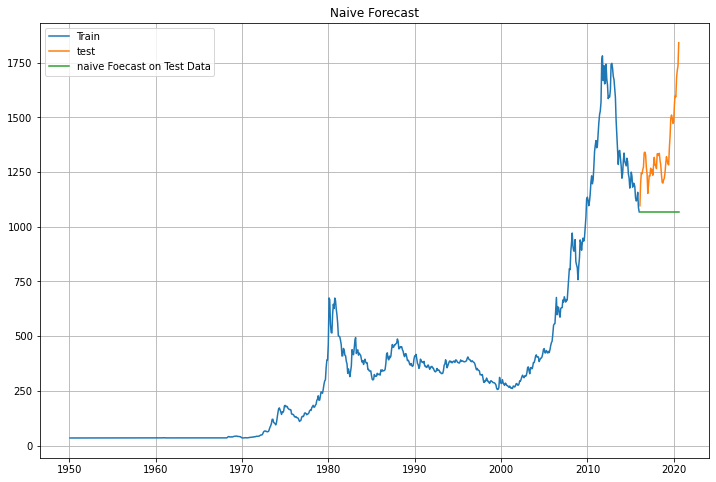

In [68]:
plt.figure(figsize = (12,8))
plt.plot(naive_train['Price'],label = 'Train')
plt.plot(test['Price'],label = 'test')
plt.plot(naive_test['naive'],label = 'naive Foecast on Test Data')
plt.legend(loc = 'best')
plt.title("Naive Forecast")
plt.grid()

In [69]:
mape_model_2_test = mape(test['Price'].values,naive_test['naive'].values)
print("For Naive forecast on test data , Mape is %3.3f"%(mape_model_2_test),"%")

For Naive forecast on test data , Mape is 19.380 %


In [70]:
results_2 = pd.DataFrame({'Test Mape (%)' :[mape_model_2_test]},index=["Naive Model"])
results = pd.concat([results,results_2])
results

,Test Mape (%)
RegressionOnTime,29.76
Naive Model,19.38


Final Forecasting

In [71]:
final_model = ExponentialSmoothing(df,trend = 'additive',
                                   seasonal = 'additive').fit(smoothing_level=0.4,
                                                              smoothing_trend = 0.3,
                                                              smoothing_seasonal = 0.6)

In [73]:
Mape_final_model = mape(df['Price'].values,final_model.fittedvalues)
print("MAPE : ",Mape_final_model)

MAPE :  17.24


In [77]:
prediction = final_model.forecast(steps = len(test))

In [78]:
pred_df = pd.DataFrame({'lower_CI' : prediction - 1.96*np.std(final_model.resid,ddof=1),
                        'prediction': prediction,
                        'upper_CI': prediction+ 1.96*np.std(final_model.resid,ddof=1)})
pred_df.head()


,lower_CI,prediction,upper_CI
2020-08-31,1684.711112,1792.862085,1901.013058
2020-09-30,1615.285245,1723.436219,1831.587192
2020-10-31,1538.533811,1646.684784,1754.835757
2020-11-30,1476.711563,1584.862536,1693.013509
2020-12-31,1459.269372,1567.420345,1675.571319


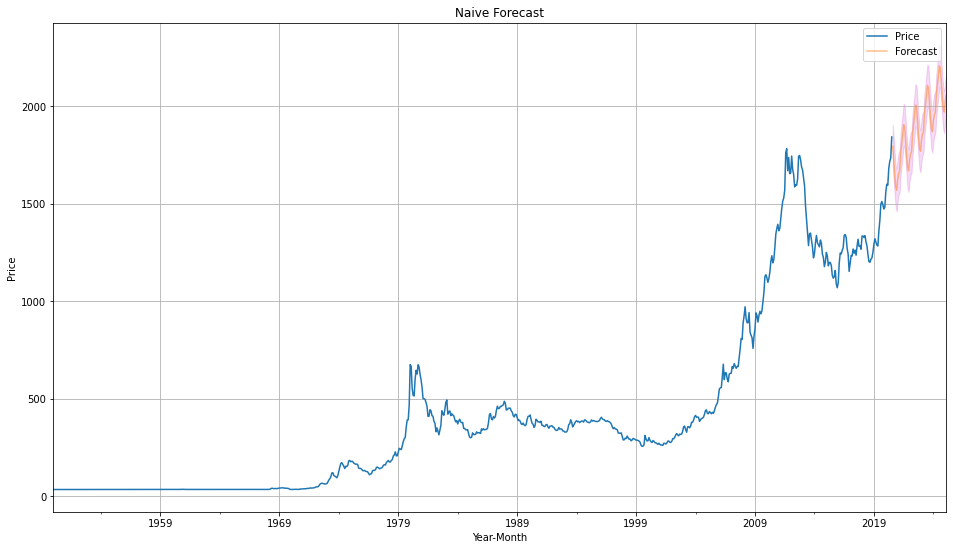

In [79]:
axis = df.plot(label = 'Actual',figsize= (16,9))
pred_df['prediction'].plot(ax = axis,label = 'Forecast' , alpha = 0.5)
axis.fill_between(pred_df.index,pred_df['lower_CI'],pred_df['upper_CI'],color = 'm',alpha= 0.15)

axis.set_xlabel('Year-Month')
axis.set_ylabel('Price')
plt.legend(loc = 'best')
plt.title("Naive Forecast")
plt.grid()